In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
import skimage.external.tifffile as tiff

from common import Statistics, dataset_source
from resources.conv_learner import *
from resources.plots import *

In [3]:
PATH = "../datasets/yeast_v5"
data_path = Path(PATH)

In [4]:
CLASSES = ('WT', 'mfb1KO', 'mfb1KO_mmr1KO', 'mmr1KO', 'mmm1KO_230', 'num1_110')
NUM_CLASSES = len(CLASSES)
BATCH_SIZE = 64
SIZE = 200

In [5]:
stats_name = "yeast_v5_per_class.dict"
test_dirs, train_dirs = dataset_source(data_path)
stats_dict = Statistics.per_class(test_dirs, train_dirs,save_name=stats_name)

working on: mfb1KO
working on: mfb1KO_mmr1KO
working on: mmr1KO
working on: WT
working on: mmm1KO_230
working on: num1_110


In [6]:
def get_data(path: str, sz, bs, stats):
    create, lbl2index = ImageClassifierData.prepare_from_path(path, val_name='test', bs=bs, balance=True)
    stats_dict = {lbl2index[key]: val for key, val in stats.items()}
    tfms = tfms_from_stats(stats_dict, sz, aug_tfms=[RandomDihedral()], pad=sz//8) #even without transformations and padding -> failure
    print('\n class to index mapping:\n',lbl2index)
    return create(tfms)

### the eventual sub-function of ImageClassifierData (read_dirs) expects subdirectories for each class: 
### e.g. all "test/cat.png" images should be in a "cat" folder. 

In [7]:
data = get_data(PATH,SIZE, BATCH_SIZE,stats_dict)

-0.018555202366876015
-0.017172535478982644
0.15949723926705456
0.01022554069958134
-0.03429450382046319
0.14697767745171808

 class to index mapping:
 {'WT': 0, 'mfb1KO': 1, 'mfb1KO_mmr1KO': 2, 'mmm1KO_230': 3, 'mmr1KO': 4, 'num1_110': 5}


In [8]:
x, y = next(iter(data.trn_dl))

In [9]:
print(y.size())

torch.Size([64])


In [ ]:
idx = 30
tiff.imshow(data.trn_ds.denorm(x[idx], y[idx].item()).squeeze()[:,:,0]); #denorm function called has a rollaxis() hence indexing changes.

# Training setup

In [ ]:
class SimpleNet(nn.Module):
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.layers:
            l_x = l(x)
            x = F.relu(l_x)
        return F.log_softmax(l_x, dim=-1)

In [ ]:
learn = ConvLearner.from_model_data(SimpleNet([200*200*2, 40, NUM_CLASSES]), data) #(!) change channel-number & classes accordingly

In [ ]:
learn, [o.numel() for o in learn.model.parameters()]

In [ ]:
learn.summary()

In [ ]:
lr=1e-5

In [ ]:
%time learn.fit(lr, 200, cycle_len=1)

## ConvNet

In [ ]:
class ConvNet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Conv2d(layers[i], layers[i + 1], kernel_size=5, stride=1, padding=(2,2))
            for i in range(len(layers) - 1)])
        self.pool = nn.AdaptiveMaxPool2d(1)
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        for l in self.layers: x = F.relu(l(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [ ]:
learn = ConvLearner.from_model_data(ConvNet([2, 20, 40, 80], 6), data)

In [ ]:
learn.summary() ### learner.summary is hardcording the number of channels = 3

In [ ]:
lr=1e-10

In [ ]:
%time learn.fit(lr, 10, cycle_len=1)

In [ ]:
torch.cuda.is_available()

## ResNet_with_Batchnorm

In [16]:
class BnLayer(nn.Module):
    def __init__(self, ni, nf, stride=2, kernel_size=3):
        super().__init__()
        self.conv = nn.Conv2d(ni, nf, kernel_size=kernel_size, stride=stride,
                              bias=False, padding=1)
        self.a = nn.Parameter(torch.zeros(nf,1,1))
        self.m = nn.Parameter(torch.ones(nf,1,1))
        
    def forward(self, x):
        x = F.relu(self.conv(x))
        x_chan = x.transpose(0,1).contiguous().view(x.size(1), -1)
        if self.training:
            self.means = x_chan.mean(1)[:,None,None]
            self.stds  = x_chan.std (1)[:,None,None]
        return (x-self.means) / self.stds *self.m + self.a

In [17]:
class ResnetLayer(BnLayer):
    def forward(self, x): return x + super().forward(x)

In [18]:
class Resnet(nn.Module):
    def __init__(self, layers, c):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 10, kernel_size=5, stride=1, padding=2)
        self.layers = nn.ModuleList([BnLayer(layers[i], layers[i+1])
            for i in range(len(layers) - 1)])
        self.layers2 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.layers3 = nn.ModuleList([ResnetLayer(layers[i+1], layers[i + 1], 1)
            for i in range(len(layers) - 1)])
        self.out = nn.Linear(layers[-1], c)
        
    def forward(self, x):
        x = self.conv1(x)
        for l,l2,l3 in zip(self.layers, self.layers2, self.layers3):
            x = l3(l2(l(x)))
        x = F.adaptive_max_pool2d(x, 1)
        x = x.view(x.size(0), -1)
        return F.log_softmax(self.out(x), dim=-1)

In [19]:
learn = ConvLearner.from_model_data(Resnet([10, 20, 40, 80, 160], 6), data)

In [20]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 2, 200, 200]),
                           ('output_shape', [-1, 10, 200, 200]),
                           ('trainable', True),
                           ('nb_params', 510)])),
             ('Conv2d-2',
              OrderedDict([('input_shape', [-1, 10, 200, 200]),
                           ('output_shape', [-1, 20, 100, 100]),
                           ('trainable', True),
                           ('nb_params', 1800)])),
             ('BnLayer-3',
              OrderedDict([('input_shape', [-1, 10, 200, 200]),
                           ('output_shape', [-1, 20, 100, 100]),
                           ('nb_params', 0)])),
             ('Conv2d-4',
              OrderedDict([('input_shape', [-1, 20, 100, 100]),
                           ('output_shape', [-1, 20, 100, 100]),
                           ('trainable', True),
                           ('nb_params', 3600)])),
             ('ResnetLayer-5',
     

In [21]:
wd=1e-5

In [14]:
%time learn.fit(1e-2, 8, cycle_len=4, wds=wd, best_save_name='Objective_A_Resnet_per_class_balanced_fromstart_1')

RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/generic/THCStorage.cu:58

In [17]:
# at very little overfitting we have 43% accuracy
%time learn.fit(1e-2, 8, wds=wd, cycle_len=10, use_clr=(20,8, 0.95, 0.85), best_save_name='Objective_A_Resnet_per_class_balanced_fromstart_2')

[0]:  0.0%                                                 
[1]:  0.2%
[2]: 0.5143%
[3]: 0.9429%
[4]: 0.3857%
[5]:  0.4%
epoch      trn_loss   val_loss   accuracy   
    0      0.762936   0.921598   0.596825  
[0]: 0.02857%                                              
[1]:  0.0%
[2]: 0.4857%
[3]: 0.9143%
[4]: 0.4429%
[5]:  0.4%
    1      0.79728    1.020787   0.565079  
[0]: 0.02857%                                              
[1]: 0.04286%
[2]: 0.6571%
[3]: 0.8571%
[4]: 0.3857%
[5]: 0.6286%
    2      0.868843   0.784458   0.644444  
[0]:  0.0%                                                 
[1]:  0.0%
[2]: 0.6857%
[3]: 0.9429%
[4]: 0.5714%
[5]: 0.1714%
    3      0.852408   1.046649   0.596825  
[0]: 0.01429%                                              
[1]:  0.0%
[2]: 0.5143%
[3]: 0.9714%
[4]: 0.7286%
[5]:  0.4%
    4      0.842904   0.929993   0.574603  
[0]: 0.01429%                                              
[1]:  0.0%
[2]: 0.7429%
[3]: 0.8857%
[4]:  0.8%
[5]:  0.8%
    

    48     0.412731   0.604163   0.726984  
[0]: 0.1571%                                               
[1]:  0.1%
[2]: 0.7714%
[3]: 0.9143%
[4]: 0.4857%
[5]: 0.4857%
    49     0.423176   0.695306   0.707937  
[0]: 0.2286%                                               
[1]:  0.2%
[2]: 0.7429%
[3]: 0.9143%
[4]:  0.3%
[5]: 0.6571%
    50     0.441346   0.817056   0.64127   
[0]: 0.08571%                                              
[1]:  0.1%
[2]:  0.8%
[3]: 0.9429%
[4]: 0.5571%
[5]:  0.4%
    51     0.447607   0.840534   0.615873  
[0]: 0.05714%                                              
[1]: 0.1571%
[2]: 0.7143%
[3]: 0.9429%
[4]: 0.6429%
[5]: 0.4571%
    52     0.456322   0.686182   0.698413  
[0]: 0.08571%                                              
[1]: 0.1429%
[2]: 0.6286%
[3]: 0.9429%
[4]: 0.6143%
[5]: 0.6857%
    53     0.445973   0.68793    0.68254   
[0]: 0.01429%                                              
[1]: 0.1429%
[2]:  0.8%
[3]: 0.9143%
[4]: 0.5857%
[5]: 0.4571%


[array([0.65114]), 0.711111108840458]

In [19]:
%time learn.fit(1e-3, 8, wds=wd, cycle_len=20, use_clr=(20,8, 0.95, 0.85), best_save_name='Objective_A_Resnet_per_class_balanced_fromstart_3')

[0]: 0.1857%                                               
[1]: 0.3143%
[2]: 0.3429%
[3]:  1.0%
[4]:  0.7%
[5]: 0.7714%
epoch      trn_loss   val_loss   accuracy   
    0      0.1267     0.421499   0.844444  
[0]: 0.1857%                                               
[1]: 0.3143%
[2]: 0.3429%
[3]:  1.0%
[4]: 0.6714%
[5]: 0.7714%
    1      0.125395   0.395248   0.853968  
[0]: 0.1571%                                               
[1]: 0.3143%
[2]: 0.3714%
[3]:  1.0%
[4]: 0.7429%
[5]: 0.7714%
    2      0.12648    0.346227   0.866667  
[0]: 0.1714%                                               
[1]: 0.3143%
[2]: 0.3429%
[3]:  1.0%
[4]: 0.7143%
[5]: 0.8571%
    3      0.127998   0.342675   0.879365  
[0]: 0.1571%                                               
[1]:  0.3%
[2]: 0.3429%
[3]:  1.0%
[4]: 0.7286%
[5]: 0.8571%
    4      0.126569   0.341496   0.869841  
[0]: 0.1571%                                               
[1]: 0.3143%
[2]: 0.3429%
[3]:  1.0%
[4]:  0.7%
[5]: 0.8857%
   

[0]: 0.1714%                                               
[1]: 0.3429%
[2]: 0.2571%
[3]:  1.0%
[4]: 0.7286%
[5]: 0.8286%
    98     0.102074   0.323798   0.873016  
[0]: 0.1714%                                                
[1]: 0.3429%
[2]: 0.2286%
[3]: 0.9714%
[4]: 0.7286%
[5]: 0.8571%
    99     0.099644   0.320497   0.873016  
[0]: 0.1714%                                                
[1]: 0.3429%
[2]: 0.2571%
[3]:  1.0%
[4]: 0.7429%
[5]: 0.8286%
   100     0.098191   0.31051    0.88254   
[0]: 0.1714%                                               
[1]: 0.3286%
[2]:  0.2%
[3]:  1.0%
[4]: 0.6857%
[5]: 0.9143%
   101     0.103095   0.364226   0.873016  
[0]: 0.1714%                                                
[1]: 0.3143%
[2]: 0.2857%
[3]:  1.0%
[4]: 0.7286%
[5]: 0.8286%
   102     0.097602   0.341312   0.863492  
[0]: 0.1714%                                                
[1]: 0.3429%
[2]: 0.3714%
[3]:  1.0%
[4]: 0.6857%
[5]: 0.8286%
   103     0.095864   0.374177   0.860

[0]: 0.1857%                                                
[1]: 0.3143%
[2]: 0.2571%
[3]:  1.0%
[4]: 0.6857%
[5]: 0.8286%
   147     0.096628   0.368414   0.853968  
[0]: 0.1714%                                                
[1]: 0.3286%
[2]: 0.2571%
[3]: 0.9714%
[4]: 0.7143%
[5]: 0.8571%
   148     0.091768   0.32927    0.879365  
[0]: 0.1857%                                                
[1]: 0.3143%
[2]: 0.2286%
[3]: 0.9714%
[4]: 0.7571%
[5]: 0.8571%
   149     0.088262   0.336212   0.860317  
[0]: 0.1714%                                                
[1]: 0.3286%
[2]: 0.1429%
[3]:  1.0%
[4]: 0.7286%
[5]: 0.9143%
   150     0.090358   0.357641   0.860317  
[0]: 0.1714%                                                
[1]: 0.3143%
[2]: 0.2286%
[3]:  1.0%
[4]: 0.7857%
[5]: 0.8286%
   151     0.090551   0.338561   0.857143  
[0]: 0.1714%                                                
[1]: 0.3286%
[2]:  0.2%
[3]: 0.9714%
[4]: 0.7429%
[5]: 0.8571%
   152     0.089507   0.329528  

[array([0.30867]), 0.8761904799748981]

In [22]:
learn.load('Objective_A_Resnet_per_class_balanced_fromstart_2')

In [23]:
%time learn.fit(1e-3, 1, wds=wd, cycle_len=1, use_clr=(20,8, 0.95, 0.85))

[0]: 0.08571%                                              
[1]: 0.1286%
[2]: 0.6857%
[3]: 0.9143%
[4]: 0.5714%
[5]: 0.6857%
epoch      trn_loss   val_loss   accuracy   
    0      0.359634   0.552267   0.75873   

CPU times: user 13.8 s, sys: 5.61 s, total: 19.4 s
Wall time: 12.9 s


[array([0.55227]), 0.7587301547565157]

[[62  3  0  0  5  0]                         
 [13 43  0  0 14  0]
 [ 0  0 35  0  0  0]
 [ 0  0  0 35  0  0]
 [ 6 20  0  0 44  0]
 [ 0  0  4  7  0 24]]


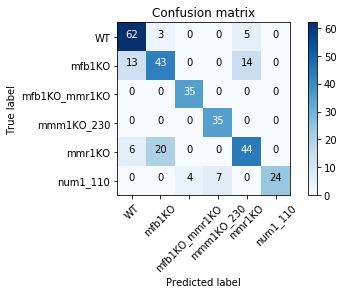

In [25]:
# analyze results 
log_preds, y = learn.TTA(n_aug=1)
log_preds_mean = np.mean(log_preds, axis=0)
preds = np.argmax(log_preds_mean, axis=1)
# cm = confusion_matrix(preds,y)
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes)